In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
# 1. Load the dataset
data = pd.read_csv('oil_userdata.csv')

# Convert 'Date' to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [114]:
# 2. Feature Engineering

# a. Moving Averages
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()

# b. Relative Strength Index (RSI)
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI'] = compute_RSI(data['Close'])

# c. Moving Average Convergence Divergence (MACD)
def compute_MACD(series, span_short=12, span_long=26, span_signal=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    MACD = ema_short - ema_long
    signal = MACD.ewm(span=span_signal, adjust=False).mean()
    return MACD, signal

data['MACD'], data['MACD_Signal'] = compute_MACD(data['Close'])

# d. Drop 'Adj Close' if not necessary
data.drop(['Adj Close'], axis=1, inplace=True)

# e. Handle missing values by forward filling
data.fillna(method='bfill', inplace=True)

In [115]:
# 3. Feature Selection
# Selecting relevant features for the model
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_Signal']
data = data[features]

In [116]:
# 4. Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [117]:
# 5. Data Splitting
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]


In [118]:
# 6. Create Sequences
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, 3])  # 'Close' is the 4th column (index 3)
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_sequences(train_data, look_back)
X_val, y_val = create_sequences(val_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)


In [119]:
# 7. Reshape for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))


In [120]:
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer
model.add(Dense(units=1))


optimizer = Adam(learning_rate=0.001)


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 60, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,851 (206.45 KB)

 Trainable params: 52,851 (206.45 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
# 9. Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 10. Train the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0431 - val_loss: 0.0012
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0043 - val_loss: 7.1769e-04
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0037 - val_loss: 7.6286e-04
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0033 - val_loss: 7.4057e-04
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 12/50
151/151 ━━━━━━━━━

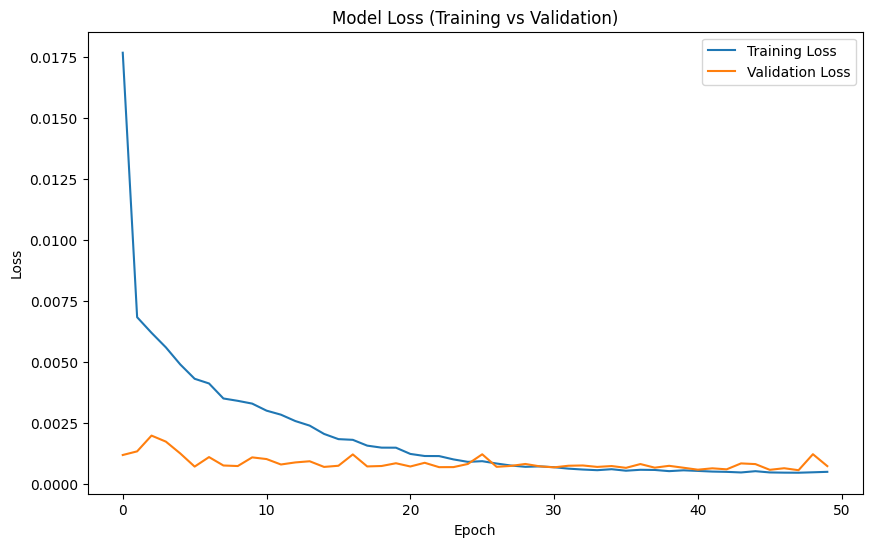

In [122]:
# 11. Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [123]:
# 12. Make Predictions on Test Set
test_predictions = model.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [124]:
# 13. Inverse Transform the Predictions and Actual Values
# Since scaler was fitted on all features, we need to create a placeholder for inverse_transform
# Create arrays with zeros for all features except 'Close'

# Prepare predicted Close prices for inverse_transform
test_pred_scaled = np.zeros((test_predictions.shape[0], len(features)))
test_pred_scaled[:, 3] = test_predictions[:, 0]  # 'Close' is index 3
test_pred_inversed = scaler.inverse_transform(test_pred_scaled)[:, 3]

# Prepare actual Close prices for inverse_transform
y_test_scaled = y_test.reshape(-1, 1)
y_test_full_scaled = np.zeros((y_test_scaled.shape[0], len(features)))
y_test_full_scaled[:, 3] = y_test_scaled[:, 0]
y_test_inversed = scaler.inverse_transform(y_test_full_scaled)[:, 3]

In [125]:
# 14. Evaluation Metrics
mae = mean_absolute_error(y_test_inversed, test_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_inversed, test_pred_inversed))
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")

Mean Absolute Error (MAE) on Test Data: 2.902456174984235
Root Mean Squared Error (RMSE) on Test Data: 3.891439350221627


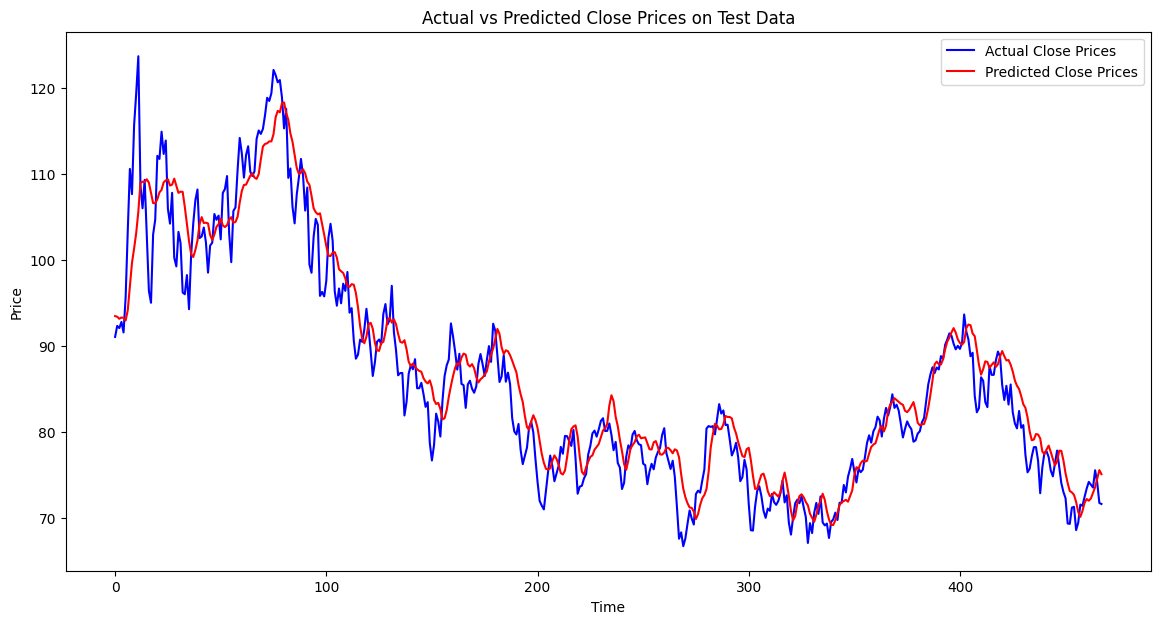

In [126]:
# 15. Plot Actual vs Predicted Prices
plt.figure(figsize=(14,7))
plt.plot(y_test_inversed, label='Actual Close Prices', color='blue')
plt.plot(test_pred_inversed, label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices on Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [127]:
# 16. Future Predictions
# To predict future prices, we need the last 'look_back' data points
future_steps = 175
input_seq = scaled_data[-look_back:]
future_predictions = []

for _ in range(future_steps):
    # Reshape to match input shape: (1, look_back, features)
    input_reshaped = np.reshape(input_seq, (1, look_back, len(features)))
    # Predict the next Close price
    pred_scaled = model.predict(input_reshaped)
    # Inverse transform the predicted Close price
    pred_full_scaled = np.zeros((1, len(features)))
    pred_full_scaled[0, 3] = pred_scaled[0, 0]
    pred_inversed = scaler.inverse_transform(pred_full_scaled)[0, 3]
    future_predictions.append(pred_inversed)
    
    # Prepare the next input sequence
    # Create a new scaled data row with the predicted Close and placeholders for other features
    # For simplicity, we'll keep other features unchanged or you can use more sophisticated methods
    new_scaled_row = scaled_data[-look_back:].copy()
    new_scaled_row = new_scaled_row[1:]  # Remove the first row
    new_scaled_features = scaled_data[-1].copy()
    new_scaled_features[3] = pred_scaled[0, 0]  # Update 'Close' with predicted value
    # Append the new row
    new_scaled_row = np.vstack([new_scaled_row, new_scaled_features])
    input_seq = new_scaled_row


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [128]:
# 17. Save Future Predictions to CSV
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
pred_df = pd.DataFrame({'Date': future_dates, 'Close price prediction': future_predictions})
pred_df.to_csv('user_future_prediction_with_features.csv', index=False)
print('Future predictions saved to user_future_prediction_with_features.csv')

Future predictions saved to user_future_prediction_with_features.csv


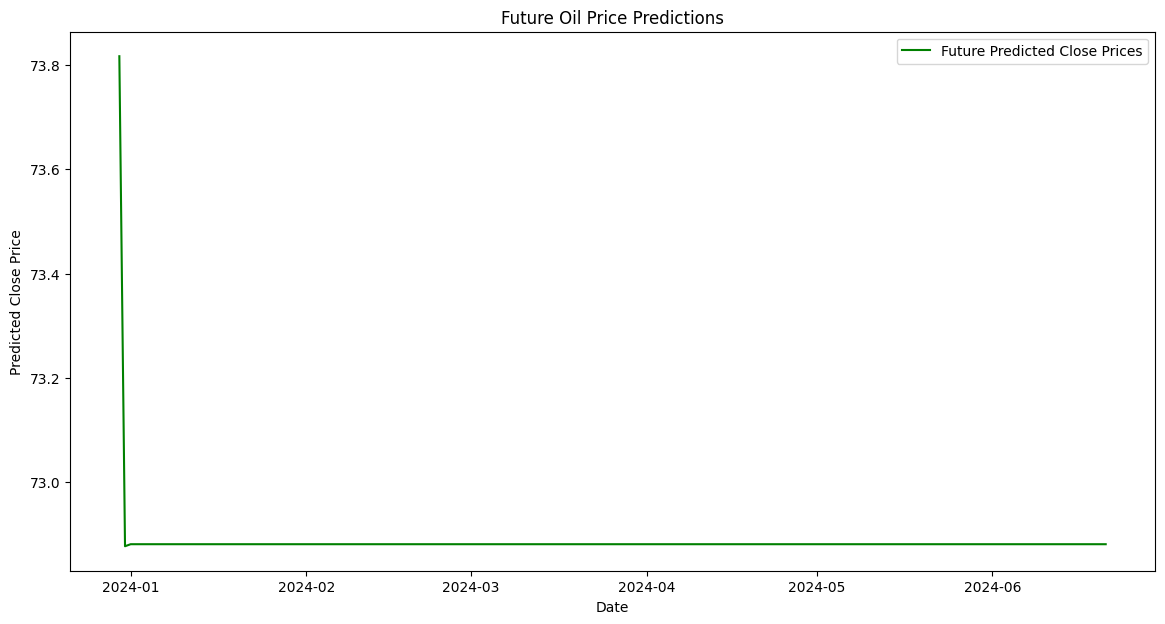

In [129]:
# 18. Plot Future Predictions
plt.figure(figsize=(14,7))
plt.plot(future_dates, future_predictions, label='Future Predicted Close Prices', color='green')
plt.title('Future Oil Price Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.show()